In [3264]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from skspatial.objects import Line, Cylinder
from skspatial.plotting import plot_3d

from numpy.random import rand
from scipy.stats import truncexpon

from scipy.integrate import quad

In [3265]:
### USEFULL FUNCTIONS ###

k2E = lambda k:81.8*(k/(2*np.pi))**2
E2k = lambda E:2*np.pi*np.sqrt(E/81.8)

theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))
Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))


### Line parametrization ###
def  line_param(t, p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]
    return np.array([p[:,0] + v[:,0]*t, p[:,1] + v[:,1]*t, p[:,2] + v[:,2]*t]).T

### Line-cylinder intersection with p0 outside ###
def CylLine_inter_fromout(geom, p, v):
    r, h = geom
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    delta[delta<0] = np.nan
    t1c, t2c = (-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)

    return np.sort((t1c, t2c), axis=0)[:2].T

### Line-cylinder intersection with p0 inside ###
def CylLine_inter_fromin(geom, p, v):
    r, h = geom
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinder
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    delta[delta<0] = np.nan
    tc = np.max([(-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)], axis=0)

    # foreword
    tc[tc<0] = np.nan

    ### planes
    # if 0 z component put to nan
    v[:,2][v[:,2]==0] = np.nan
    #  and find intercept
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0)
    
    return np.sort((tc, tz), axis=0)[0].T

### Line-cuboid intersection with p0 outside ###
def CubLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the x walls!
    dx, dy, dz = geom
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    # intercepts
    t1x, t2x = (-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]

    # foreword
    t1x[t1x<=0] = np.nan
    t2x[t2x<=0] = np.nan

    return np.sort([t1x, t2x])[:2].T

### Line-cuboid intersection with p0 inside ###
def CubLine_inter_fromin(geom, p, v):
    dx, dy, dz = geom
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # intercepts
    tx = np.max([(-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]], axis=0)
    ty = np.max([(-dy/2 - p[:,1])/v[:,1], (+dy/2 - p[:,1])/v[:,1]], axis=0)
    tz = np.max([(-dz/2 - p[:,2])/v[:,2], (+dz/2 - p[:,2])/v[:,2]], axis=0)
    
    return np.sort((tx, ty, tz), axis=0)[0].T


###############################
###### NEUTRON GENERATION #####
###############################

def ngen_4_Cyl(geom, d_a2c, N):
    r, h = geom
    return np.array([[-d_a2c]*N, rand(N) * 2*r - r, rand(N) * h - h/2]).T

def ngen_4_Cub(geom, d_a2c, N):
    dx, dy, dz = geom
    return np.array([[-d_a2c]*N, rand(N) * dy - dy/2, rand(N) * dz - dz/2]).T


# Monte carlo simulation of inelastic multiple scattering (Cylinder)

# Variables for simulation

## Geometry

In [3266]:
#####################
###### Geometry #####
#####################

### Cylinder geometry ###
r = .3 #cm # radius of the cylinder
h = 4 #cm # height of the cylinder

### Cuboid geometry ###
dx, dy, dz = .1, 3, 4  #cm

geometry = 'cylinder'

### Experiment geometry ###
d_a2c = 100 #cm

### "detector" apertures
dtheta = 0.01
dphi = 0.01
domega = .1

In [3267]:
if geometry=='cuboid':
    geom=(dx,dy,dz)
    ngen = lambda N: ngen_4_Cub(geom, d_a2c, N)
    inter_fromout = lambda p, v: CubLine_inter_fromout(geom, p, v)
    inter_fromin  = lambda p, v: CubLine_inter_fromin (geom, p, v)

elif geometry=='cylinder':
    geom = (r, h)
    ngen = lambda N: ngen_4_Cyl(geom, d_a2c, N)
    inter_fromout = lambda p, v: CylLine_inter_fromout(geom, p, v)
    inter_fromin  = lambda p, v: CylLine_inter_fromin (geom, p, v)

## Scattering lenghts

In [3268]:
##############################
##### Scattering lenghts #####
##############################

mu_s = .7 #cm^-1
mu_abs = 0.0 #cm^-1

## Montecarlo reps

In [3269]:
###############################
##### # of Montecrlo reps #####
###############################

N=1000000

N_bunch = 100

## Scattering geometry

In [3270]:
####################################
##### Scattering configuration #####
####################################

### Incident energy ###
ki = 5.8 #A^-1
Ei = k2E(ki) #meV

### Final energy ###
kf = 5.
Ef = k2E(kf)
omega = Ei - Ef

### Scattering angle / Q ###
theta = np.deg2rad(10)
Q = theta2Q(omega, ki, theta)

## S(Q, $\omega$)

In [3271]:
##################
##### S(Q,w) #####
##################

# LOAD S(Q,E)
S_mesh = np.load('./data_Sq/Sqw_test/S_mesh.npy')
Q_mesh = np.load('./data_Sq/Sqw_test/Q_mesh.npy')
omega_mesh = np.load('./data_Sq/Sqw_test/omega_mesh.npy')

# Usefull vectors
omega_vec = omega_mesh[0,:]
Q_vec = Q_mesh[:,0]
dQ_vec = Q_vec[1]-Q_vec[0]
domega_vec = omega_vec[1]-omega_vec[0]

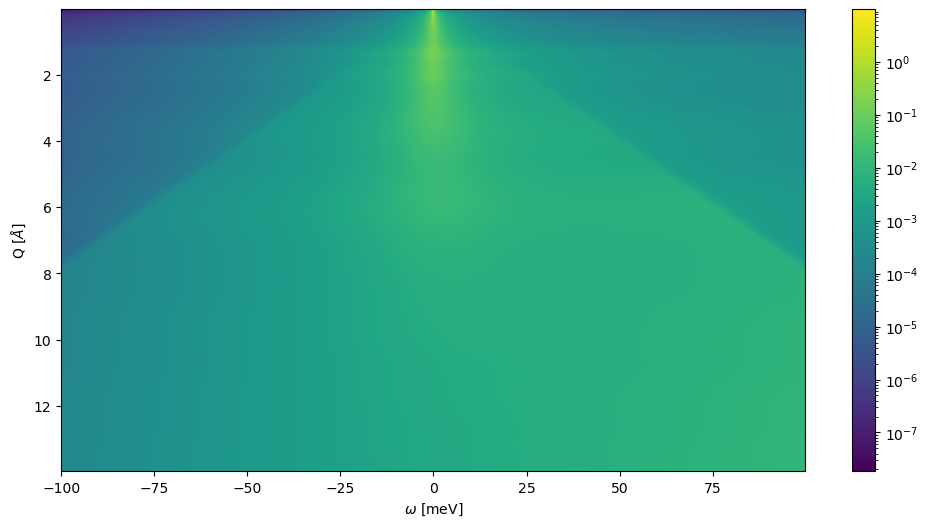

In [3272]:
# Useful object for plots
S_imshow_extent = [omega_vec.min(),omega_vec.max(),Q_vec.max(),Q_vec.min()]

# plot
plt.figure(figsize=(12,6))
plt.imshow(S_mesh, norm='log', cmap='viridis', aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

# Initial calculations

## Dynamc range for direct scattering event
$$
Q = ki \sqrt{2-\frac{\omega}{E_i}-2*\sqrt{1-\frac{\omega}{E_i}}\cos(\theta)}

In [3273]:
###############################################
##### Dynamic range for direct scattering #####
###############################################

Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))

/tmp/ipykernel_47480/1737001185.py:5: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
/tmp/ipykernel_47480/1737001185.py:6: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))


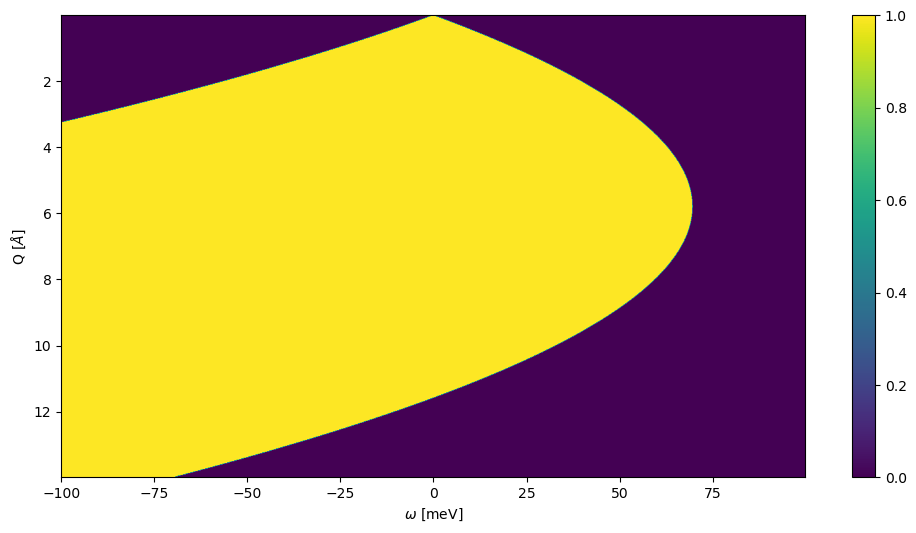

In [3274]:
# usage example
out = (Q_mesh>Q_lowlim(ki)) & (Q_mesh<Q_uplim(ki))

# plot
plt.figure(figsize=(12,6))
plt.imshow(out, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

## dQ-$d\theta$ relation

$$ a = 2-\omega/E_i \hspace{2cm} b=2\sqrt{1-\omega/E_i} $$
$$ \Rightarrow dQ = k_i^2/2 \frac{b \sin{\theta}}{\sqrt{a-b\cos{\theta}}} d\theta

In [3275]:
##############################
##### dQ-dtheta relation #####
##############################

def dqdtheta(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))

def dthetadq(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return (ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta)))**-1

/tmp/ipykernel_47480/4116257525.py:8: RuntimeWarning: invalid value encountered in divide
  return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))
/tmp/ipykernel_47480/4116257525.py:7: RuntimeWarning: invalid value encountered in sqrt
  b = 2*np.sqrt(1-omega/k2E(ki))


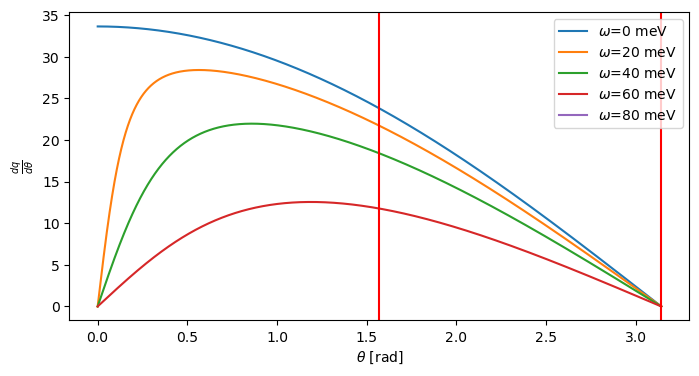

In [3276]:
# plot
X = np.linspace(0, np.pi, 10000)

plt.figure(figsize=(8,4))
plt.plot(X, dqdtheta(0, ki, X), label='$\omega$=0 meV')
plt.plot(X, dqdtheta(20, ki, X), label='$\omega$=20 meV')
plt.plot(X, dqdtheta(40, ki, X), label='$\omega$=40 meV')
plt.plot(X, dqdtheta(60, ki, X), label='$\omega$=60 meV')
plt.plot(X, dqdtheta(80, ki, X), label='$\omega$=80 meV')

plt.axvline(np.pi, c='red')
plt.axvline(np.pi/2, c='red')

plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\frac{dq}{d\theta}$')
plt.legend()

## Cut of S(Q, $\omega$) for $k_i$

In [3277]:
####################################
##### Cut of the S(Q,w) for Ei #####
####################################
# than normalized (in Q)

S_mesh_cutEi = ((Q_mesh>Q_lowlim(ki)) & (Q_mesh<Q_uplim(ki))) * S_mesh
S_mesh_cutEi /= S_mesh_cutEi.sum() * dQ_vec*domega_vec

/tmp/ipykernel_47480/1737001185.py:5: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
/tmp/ipykernel_47480/1737001185.py:6: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))


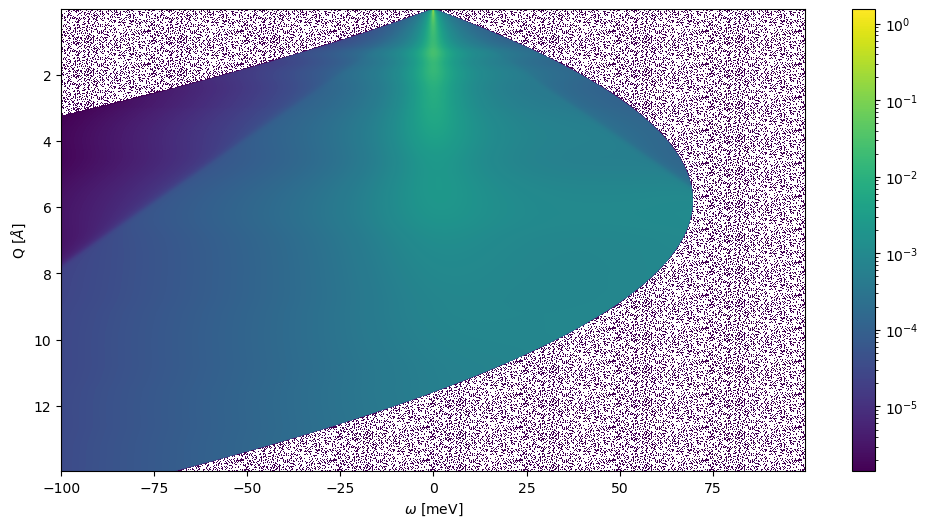

In [3278]:
# plot
plt.figure(figsize=(12,6))
plt.imshow(S_mesh_cutEi, aspect='auto', norm='log', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

## Lamber-Beer law

In [3279]:
###########################
##### Lamber-Beer law #####
###########################

# Trasmission
T = lambda d: np.exp(-mu_s*d)

# Random scattering extraction from Lamber-Beer law
rand_LB = lambda b: truncexpon.rvs(b = b*mu_s)/mu_s

# The simulation

## Randomly generate N neutrons at x=-d_a2c, random z = [-h/2, h/2] and y[-r, r]

In [3280]:
##########################
##### THE SIMULATION #####
##########################

##### RANDOMLY GENERATE N NEUTRONS #####
# from uniform beam at x=-d_a2c, random z = [-h/2, h/2] and y[-r, r]

p0 = ngen(N)
k0 = np.array([[ki, 0, 0]]*N)
w0 = np.array([1]*N)

Text(0.5, 0, 'z0 [cm]')

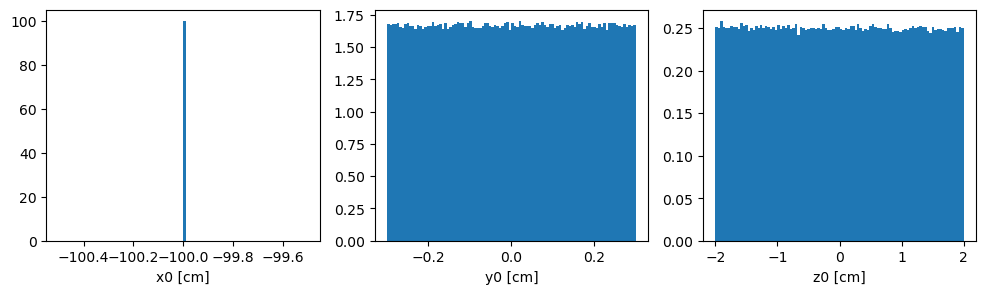

In [3281]:
# plots
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.hist(p0[:,0], bins=100, density=True);
plt.xlabel('x0 [cm]')
plt.subplot(1,3,2)
plt.hist(p0[:,1], bins=100, density=True);
plt.xlabel('y0 [cm]')
plt.subplot(1,3,3)
plt.hist(p0[:,2], bins=100, density=True);
plt.xlabel('z0 [cm]')

In [3282]:
# dimensions of the vectors
print('p0:', p0.nbytes/1e6, 'MB')
print('k0:', k0.nbytes/1e6, 'MB')
print('w0:', w0.nbytes/1e6, 'MB')

p0: 24.0 MB
k0: 24.0 MB
w0: 8.0 MB


## Extract the scattering positions

In [3283]:
### EXTRACT THE 1st SCATTERING EVENT ###

# intercept calculation
ts = inter_fromout(p0, k0)
t1, t2 = ts[:,0], ts[:,1]
del ts

d1 = t2 - t1

# trasmission calc and weight update (w1, T1)
T1 = T(d1)
w1 = w0 * (1-T1)

# event position extraction (p1)
dtp1 = rand_LB(d1)
p1 = line_param(t1+dtp1, p0, k0)
del t1, t2, dtp1

Text(0, 0.5, 'z [cm]')

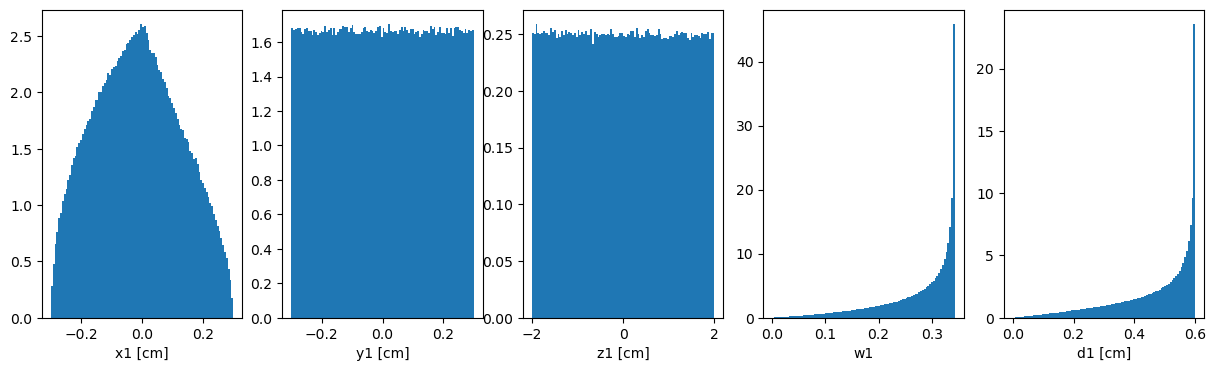

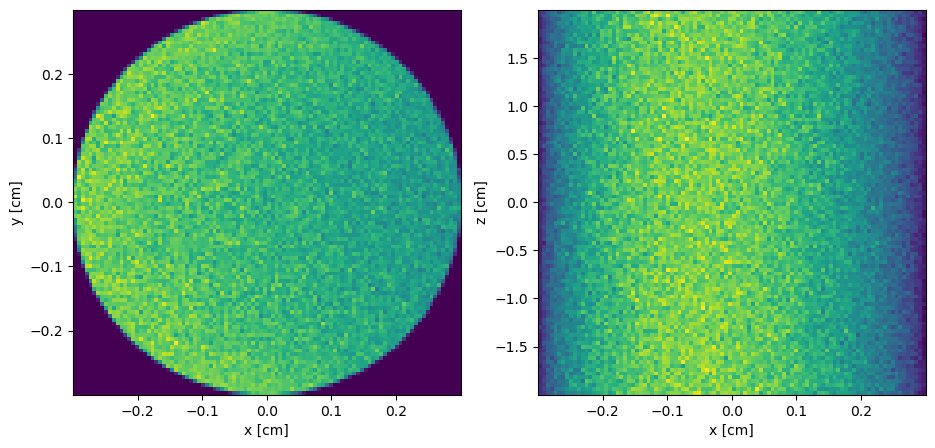

In [3284]:
# plots
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,5,1)
plt.hist(p1[:,0], bins=100, density=True);
plt.xlabel('x1 [cm]')
plt.subplot(1,5,2)
plt.hist(p1[:,1], bins=100, density=True);
plt.xlabel('y1 [cm]')
plt.subplot(1,5,3)
plt.hist(p1[:,2], bins=100, density=True);
plt.xlabel('z1 [cm]')
plt.subplot(1,5,4)
plt.hist(w1, bins=100, density=True);
plt.xlabel('w1')
plt.subplot(1,5,5)
plt.hist(d1, bins=100, density=True);
plt.xlabel('d1 [cm]')

# heatmap
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p1[:,0], p1[:,1], bins=100, weights=w1);
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(1,2,2)
plt.hist2d(p1[:,0], p1[:,2], bins=100, weights=w1);
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')

In [3285]:
# dimensions of the vectors
print('p1:', p1.nbytes/1e6, 'MB')
print('w1:', w1.nbytes/1e6, 'MB')

p1: 24.0 MB
w1: 8.0 MB


## Probability of single scattering

### Find k1 and omega1 imposing collimator angle

In [3286]:
### PROBABILITY OF SINGLE SCATTERING ###

# Find k1, omega1, Q1 imposing collimator angle
k1s = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
Q1s = np.linalg.norm(k0 - k1s, axis=1)
omega1s = (Ei - Ef) * np.ones(N)
theta1s = theta

### Scattering probability from the PDF

$$ P(Q,\omega) = S(Q,\omega) d\omega dQ = S(Q,\omega) d\omega \frac{dQ}{d\theta} d\theta $$

In [3287]:
# Get the scattering probavilities from S_mesh_cutEi (w1s)
Q_idx = np.searchsorted(Q_vec, Q1s)
omega_idx = np.searchsorted(omega_vec, omega1s)

w1s = w1 * S_mesh_cutEi[Q_idx, omega_idx] * dqdtheta(omega1s, ki, theta1s) * dtheta * dphi * domega

### Single scattering intercept and trasmission


In [3288]:
# Trasmission probability from p0 to detector
t1 = inter_fromin(p1, k1s)
d1s = t1
T1s = T(d1s)

wfs = w1s*T1s

Text(0, 0.5, 'wfs')

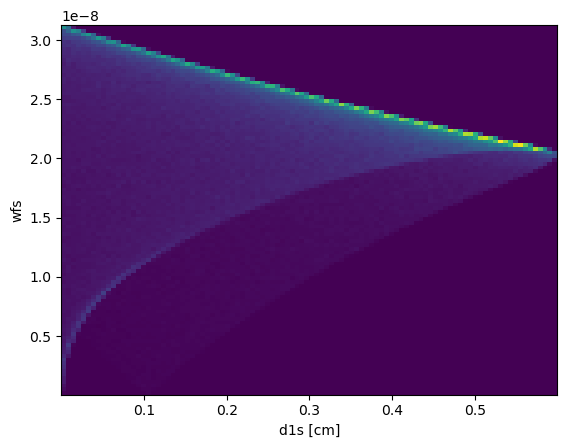

In [3289]:
# plot
plt.hist2d(d1s, wfs, bins=100);
plt.xlabel('d1s [cm]')
plt.ylabel('wfs')

## Multiple scattering path

### Extraction from the S(Q, omega)

$$ P(Q,\omega) = S(Q,\omega) d\omega dQ = S(Q,\omega) \frac{dQ}{d\theta} d\theta  d\omega$$

#### $\frac{dQ}{d\theta}$

In [3290]:
####################################
##### MULTIPLE SCATTERING PATH #####
####################################

### EXTRACTION FROM S(q,W) ###

# dQdtheta on the mesh
dqdtheta_pdf = np.nan_to_num(dqdtheta(omega_mesh, ki, Q2theta(omega_mesh, ki, Q_mesh)))

/tmp/ipykernel_47480/902400623.py:7: RuntimeWarning: invalid value encountered in sqrt
  Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))
/tmp/ipykernel_47480/902400623.py:7: RuntimeWarning: invalid value encountered in arccos
  Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))


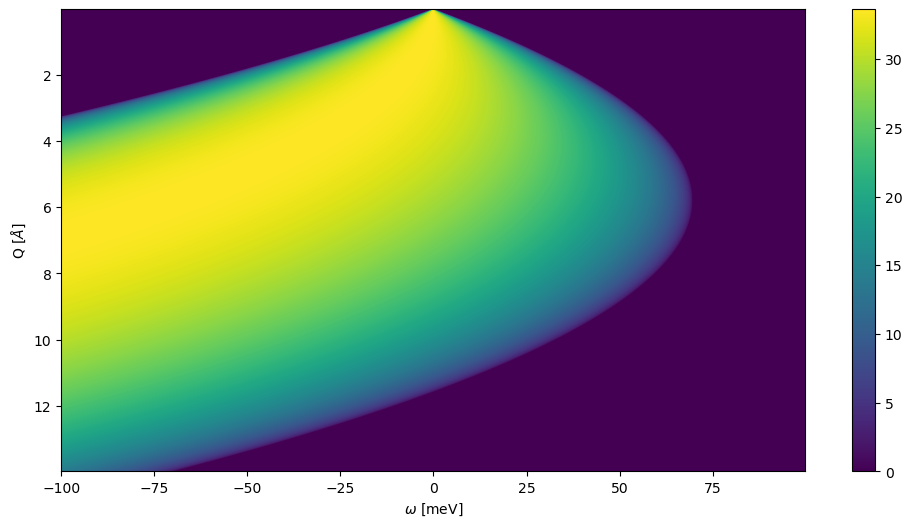

In [3291]:
# plot
plt.figure(figsize=(12,6))
plt.imshow(dqdtheta_pdf, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

In [3292]:
# Probaility mesh for random choiches
PDF = S_mesh * dqdtheta_pdf # * dtheta * domega
PDF /= PDF.sum() # * dtheta * domega

In [3293]:
# Random extractions
is_mesh = np.random.choice(np.arange(PDF.shape[0]*PDF.shape[1]), p=PDF.reshape(-1), size=N)

# Extracted scattering variables
Q1m = Q_mesh.reshape(-1)[is_mesh]
omega1m = omega_mesh.reshape(-1)[is_mesh]
theta1m = Q2theta(omega1m, ki, Q1m)
E1m = Ei - omega1m
w1m = w1

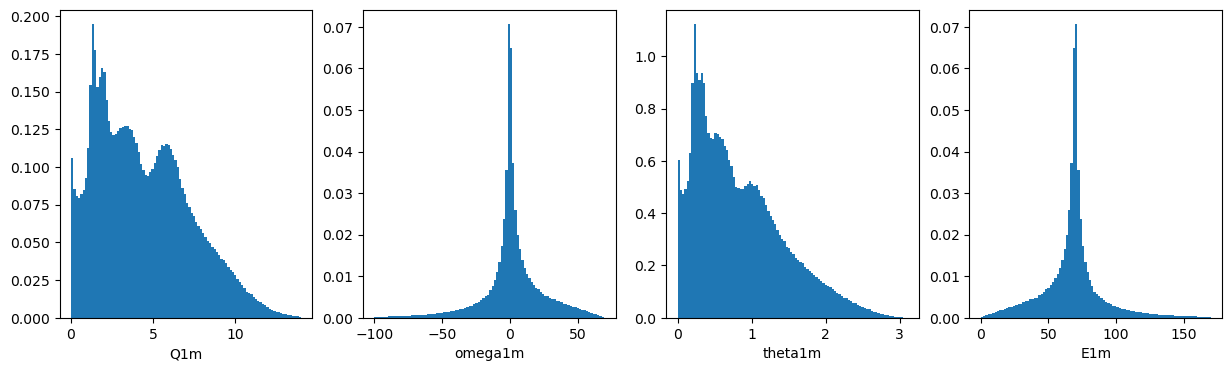

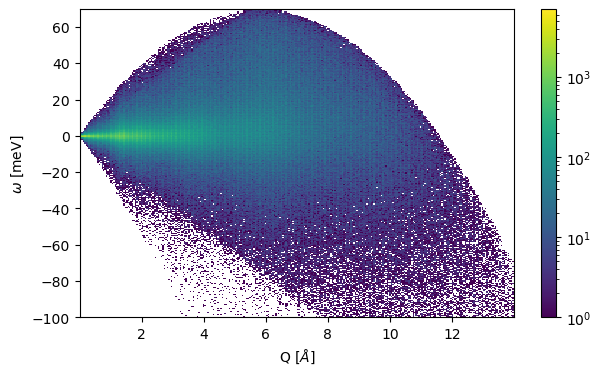

In [3294]:
# plot
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.hist(Q1m, bins=100, density=True);
plt.xlabel('Q1m')
plt.subplot(1,4,2)
plt.hist(omega1m, bins=100, density=True);
plt.xlabel('omega1m')
plt.subplot(1,4,3)
plt.hist(theta1m, bins=100, density=True);
plt.xlabel('theta1m')
plt.subplot(1,4,4)
plt.hist(E1m, bins=100, density=True);
plt.xlabel('E1m')

# 3D
plt.figure(figsize=(7,4))
plt.hist2d(Q1m, omega1m, bins=300, norm=colors.LogNorm());
plt.ylabel('$\omega$ [meV]')
plt.xlabel('Q [$\AA$]')
plt.colorbar()

### Creation of the scattering vector

In [3295]:
### NEW NEUTRON MOMENTA ###

# Random angle on the scattering cone
phi1m = rand(N)*2*np.pi

In [3296]:
# Neutrom momenta after scattering
k1m = (np.array((np.cos(theta1m), np.sin(theta1m)*np.cos(phi1m), np.sin(theta1m)*np.sin(phi1m))) * E2k(E1m)).T
k1m_mod = E2k(E1m)

Text(0, 0.5, 'z [cm]')

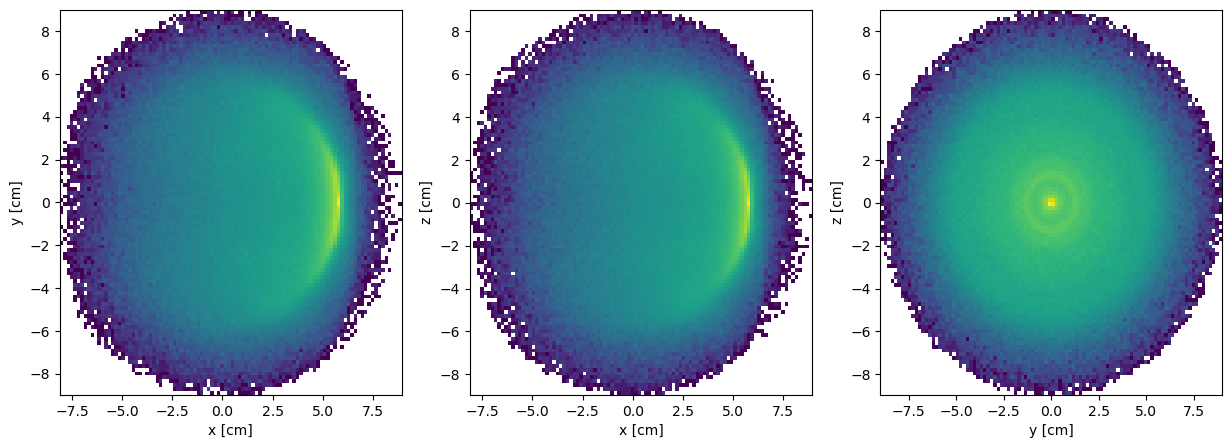

In [3297]:
# plot
# heatmap
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(k1m[:,0], k1m[:,1], bins=100, norm=colors.LogNorm());
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(1,3,2)
plt.hist2d(k1m[:,0], k1m[:,2], bins=100, norm=colors.LogNorm());
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.subplot(1,3,3)
plt.hist2d(k1m[:,1], k1m[:,2], bins=100, norm=colors.LogNorm());
plt.xlabel('y [cm]')
plt.ylabel('z [cm]')

### Extract a new scattering position for multiple

In [3298]:
### EXTRACT 2nd SCATTERING POSITION ###

# intercept calculation (from inside the sample)
ts = inter_fromin(p1, k1m)
d2m = ts

# trasmission calc and weight update (w2m, T2m)
T2m = T(d2m)
w2m = w1m * (1-T2m)

# event position extraction (p2)
dtp2 = rand_LB(d2m)
p2 = line_param(dtp2, p1, k1m)
#del ts, dtp2

Text(0, 0.5, 'z [cm]')

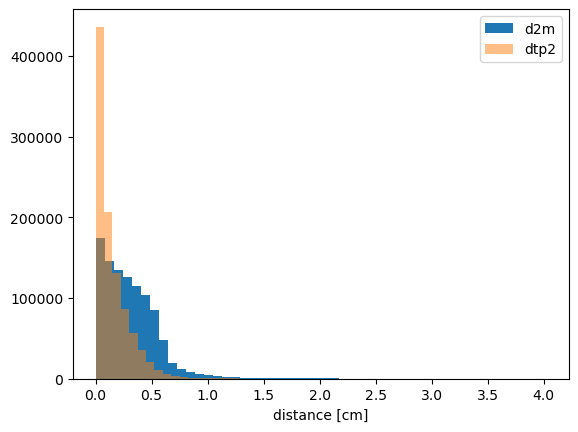

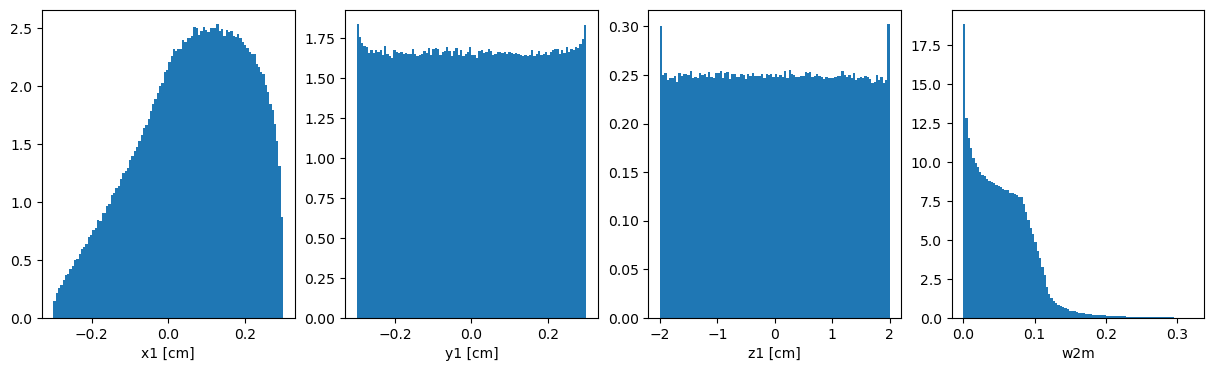

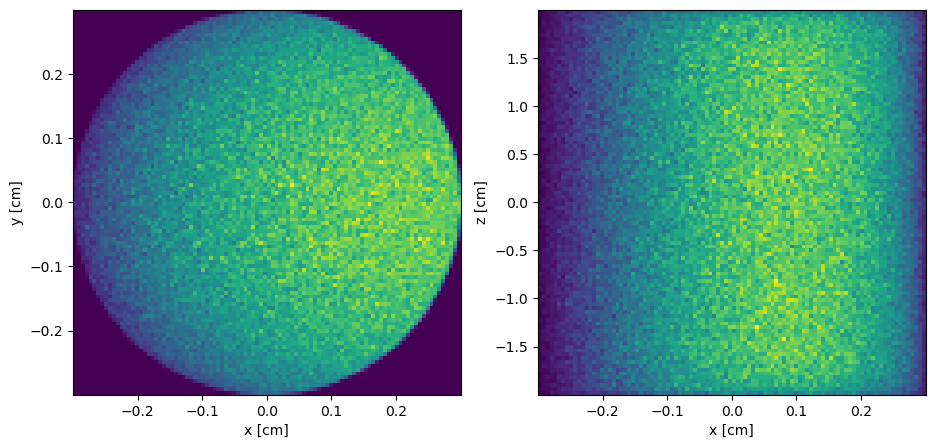

In [3299]:
# plot
# plots
plt.hist(d2m, bins=50, label='d2m')
plt.hist(dtp2, bins=50, alpha=.5, label='dtp2')
plt.legend()
plt.xlabel('distance [cm]')

# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.hist(p2[:,0], bins=100, density=True);
plt.xlabel('x1 [cm]')
plt.subplot(1,4,2)
plt.hist(p2[:,1], bins=100, density=True);
plt.xlabel('y1 [cm]')
plt.subplot(1,4,3)
plt.hist(p2[:,2], bins=100, density=True);
plt.xlabel('z1 [cm]')
plt.subplot(1,4,4)
plt.hist(w2m, bins=100, density=True);
plt.xlabel('w2m')

# heatmap
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p2[:,0], p2[:,1], bins=100, weights=w2m);
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(1,2,2)
plt.hist2d(p2[:,0], p2[:,2], bins=100, weights=w2m);
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')

### Find k2 and omega2 imposing collimator angle

In [3300]:
### Find k2m, omega2m, Q2m imposing collimator angle ###
k2m = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
omega2m = (E1m - Ef) * np.ones(N)
Q2m = np.linalg.norm(k1m - k2m, axis=1)

theta2m = Q2theta(omega2m, E2k(E1m), Q2m)

In [3301]:
### Mask of impossible events
mask2m = ~((Q2m>Q_vec.max()) | (Q2m<Q_vec.min()) | (omega2m>omega_vec.max()) | (omega2m<omega_vec.min()) | np.isnan(theta2m))

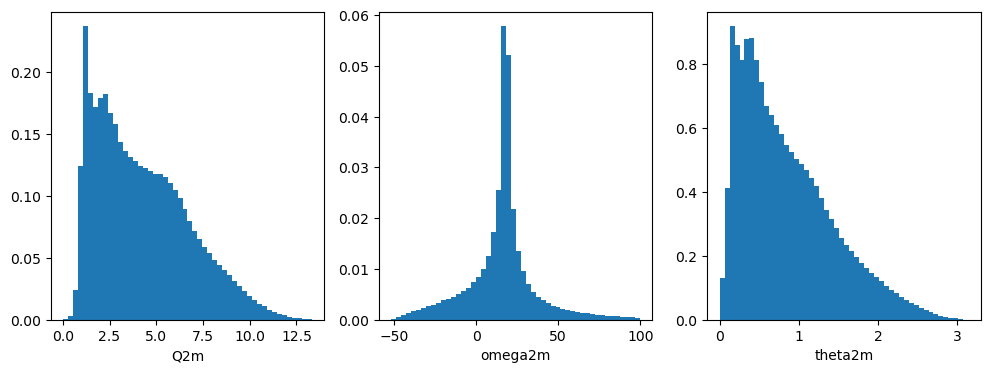

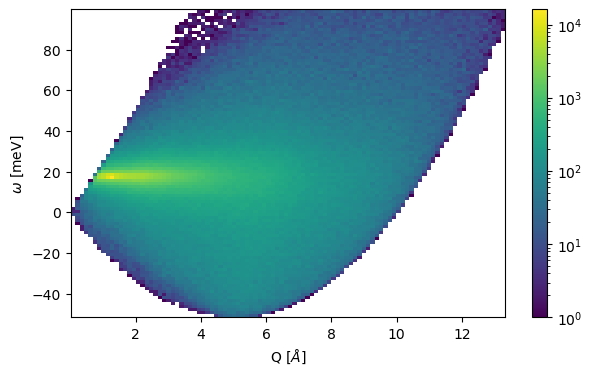

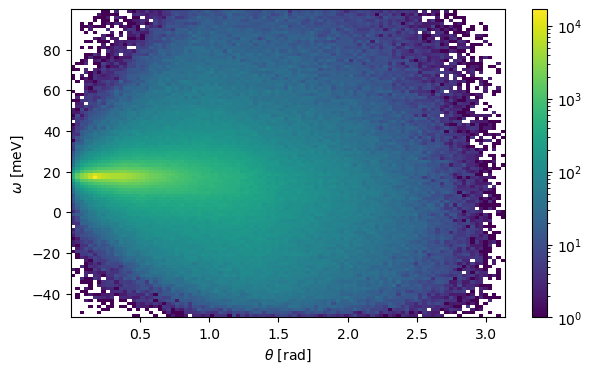

In [3302]:
#plot
# 2D
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(Q2m[mask2m], bins=50, density=True);
plt.xlabel('Q2m')
plt.subplot(1,3,2)
plt.hist(omega2m[mask2m], bins=50, density=True);
plt.xlabel('omega2m')
plt.subplot(1,3,3)
plt.hist(theta2m[mask2m], bins=50, density=True);
plt.xlabel('theta2m')

plt.figure(figsize=(7,4))
plt.hist2d(Q2m[mask2m], omega2m[mask2m], bins=100, norm=colors.LogNorm());
plt.ylabel('$\omega$ [meV]')
plt.xlabel('Q [$\AA$]')
plt.colorbar()

plt.figure(figsize=(7,4))
plt.hist2d(theta2m[mask2m], omega2m[mask2m], bins=100, norm=colors.LogNorm());
plt.ylabel('$\omega$ [meV]')
plt.xlabel(r'$\theta$ [rad]')
plt.colorbar()

### Scattering probability from the PDF

### Bunching the cuts in S(Q,W) for speed up

In [3303]:
### SCATTERING PROBABILITIES FROM THE PDF $$$

# Bunching the initial energies E1m
E_min = E1m[mask2m].min()
E_max = E1m[mask2m].max()
bunch = np.linspace(E_min, E_max, N_bunch)[1:]
dbunch = (bunch[1]-bunch[0])

# find the bunch indexes
bunch_idx = np.searchsorted(bunch, E1m, side='left')
bunch_idx[~mask2m] = -1 # putting impossible events with idx=-1, i.e. in the next part P stay 0

In [3304]:
# indexing Q2m and omega2m on the mesh
Q_idx = np.searchsorted(Q_vec, Q2m)
omega_idx = np.searchsorted(omega_vec, omega2m)

In [3305]:
# calculating probabilities at bunches
P = np.zeros(N)

for b in range(N_bunch-1):
    S_mesh_cut = ((Q_mesh>Q_lowlim(E2k(bunch[b]-dbunch/2))) & (Q_mesh<Q_uplim(E2k(bunch[b]-dbunch/2)))) * S_mesh
    S_mesh_cut /= S_mesh_cut.sum() * dQ_vec * domega_vec

    P[bunch_idx==b] = S_mesh_cut[Q_idx[bunch_idx==b], omega_idx[bunch_idx==b]] * dqdtheta(omega2m[bunch_idx==b], k1m_mod[bunch_idx==b], theta2m[bunch_idx==b]) * dtheta * dphi * domega

# updating the weights
w3m = w2m * P

/tmp/ipykernel_47480/1737001185.py:5: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
/tmp/ipykernel_47480/1737001185.py:6: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))


### Trasmission of multiple event to the detector

In [3306]:
# Trasmission probability from p2 to detector
t1 = inter_fromin(p1, k1s)
d3m = t1
T3m = T(d3m)

wfm = w3m*T3m

## Final results

In [3307]:
Is = wfs.mean()
Im = wfm.mean()

print('Is:', Is, 'Im:', Im)
print(Im/Is)

Is: 2.1109402046294265e-08 Im: 1.1051729592281796e-08
0.5235453646694799


## Data analysis


Text(0.5, 0, '$\\theta$ [deg]')

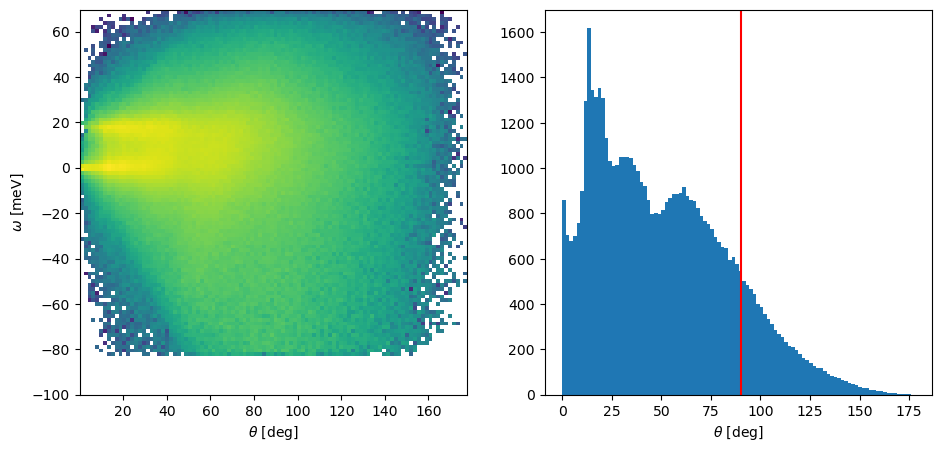

In [3308]:
# heatmap
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(np.rad2deg(theta1m), omega1m, bins=100, weights=wfm, norm=colors.LogNorm());
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('$\omega$ [meV]')

plt.subplot(1,2,2)
plt.hist(np.rad2deg(theta1m), bins=100, weights=w2m);
plt.axvline(90, c='r')
plt.xlabel(r'$\theta$ [deg]')